In [127]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import matplotlib.ticker as ticker
import os 
import pickle

Laad bestanden

In [128]:
#Load files
location = 'Budel'
modelname = 'Vlen'

results = pd.read_csv(rf'C:\Users\leermdv\OneDrive - TNO\Documents\Python Scripts\ExtractionCalibrator\Results\{location} Output\{modelname}\RMSE_all.csv', names = ['sim', 'RMSE', 'xcorlen', 'zcorlen','frac', 'cc'])
best = xr.open_dataset(rf'C:\Users\leermdv\OneDrive - TNO\Documents\Python Scripts\ExtractionCalibrator\Results\{location} Output\{modelname}\BestRealizations.nc')
Residuals = pd.read_csv(rf"C:\Users\leermdv\OneDrive - TNO\Documents\Python Scripts\ExtractionCalibrator\Results\{location} Output\{modelname}\Residuals_{modelname}.csv", index_col = "Time")
Performance = pd.read_csv(rf"C:\Users\leermdv\OneDrive - TNO\Documents\Python Scripts\ExtractionCalibrator\Results\{location} Output\{modelname}\Calibration_Performance_{modelname}.csv")
BestParamsSS = pd.read_csv(rf"C:\Users\leermdv\OneDrive - TNO\Documents\Python Scripts\ExtractionCalibrator\Results\{location} Output\{modelname}\BestParams_SS_{modelname}.csv", names = ['param', 'value'], header = 0, index_col = 'param' )
BestParamst = pd.read_csv(rf"C:\Users\leermdv\OneDrive - TNO\Documents\Python Scripts\ExtractionCalibrator\Results\{location} Output\{modelname}\BestParams_t_{modelname}.csv", names = ['param', 'value'], header = 0, index_col = 'param' )
ModHeads = pd.read_csv(rf"C:\Users\leermdv\OneDrive - TNO\Documents\Python Scripts\ExtractionCalibrator\Results\{location} Output\{modelname}\ModHead_{modelname}.csv", index_col = "Time")
ModHeads.index =  pd.DatetimeIndex(ModHeads.index)
ObsHeads = pd.read_csv(rf"C:\Users\leermdv\OneDrive - TNO\Documents\Python Scripts\ExtractionCalibrator\Results\{location} Output\{modelname}\ObsHead_{modelname}.csv", index_col = "Time")
ObsHeads.index =  pd.DatetimeIndex(ObsHeads.index)
ObsWells = pd.read_csv(rf"C:\Users\leermdv\OneDrive - TNO\Documents\Python Scripts\ExtractionCalibrator\Results\{location} Output\{modelname}\ObsForCalibration_{modelname}_SS.csv")
ExWells = pd.read_csv(os.path.join('..','Data','dawaco',f'winputten_WG_Budel.csv'))
ds = xr.open_dataset(rf"C:\Users\leermdv\OneDrive - TNO\Documents\Python Scripts\ExtractionCalibrator\Results\Budel Output\{modelname}\{modelname}_ss\{modelname}_ss.nc")

with open(rf"C:\Users\leermdv\OneDrive - TNO\Documents\Python Scripts\ExtractionCalibrator\Results\Budel Output\{modelname}\boreholeindicators.pkl", 'rb') as f:
    boringen = pickle.load(f)
RMSE_ref = Performance['RMSE'][0]
KGE_ref = Performance['KGE'][17]

0.1219858607248132


In [129]:

K_SS = BestParamsSS[~BestParamsSS.index.str.endswith('b')]
K_SS = 2**K_SS
K_T= 2**BestParamst[~BestParamst.index.str.startswith('SS')]
SS = 10**BestParamst[BestParamst.index.str.startswith('SS')]

Params = pd.concat([K_SS * K_T, SS, BestParamsSS[BestParamsSS.index.str.endswith('b')] ])
Params

value
param             
KIz2      3.677247
KIk2      6.071213
KIz3      0.396398
KIk3      1.278905
KIz4      0.470843
SSz       1.923407
SSk       2.578643
KIz2_ghb -0.675739
KIz3_ghb -2.207133
KIz4_ghb -0.361052

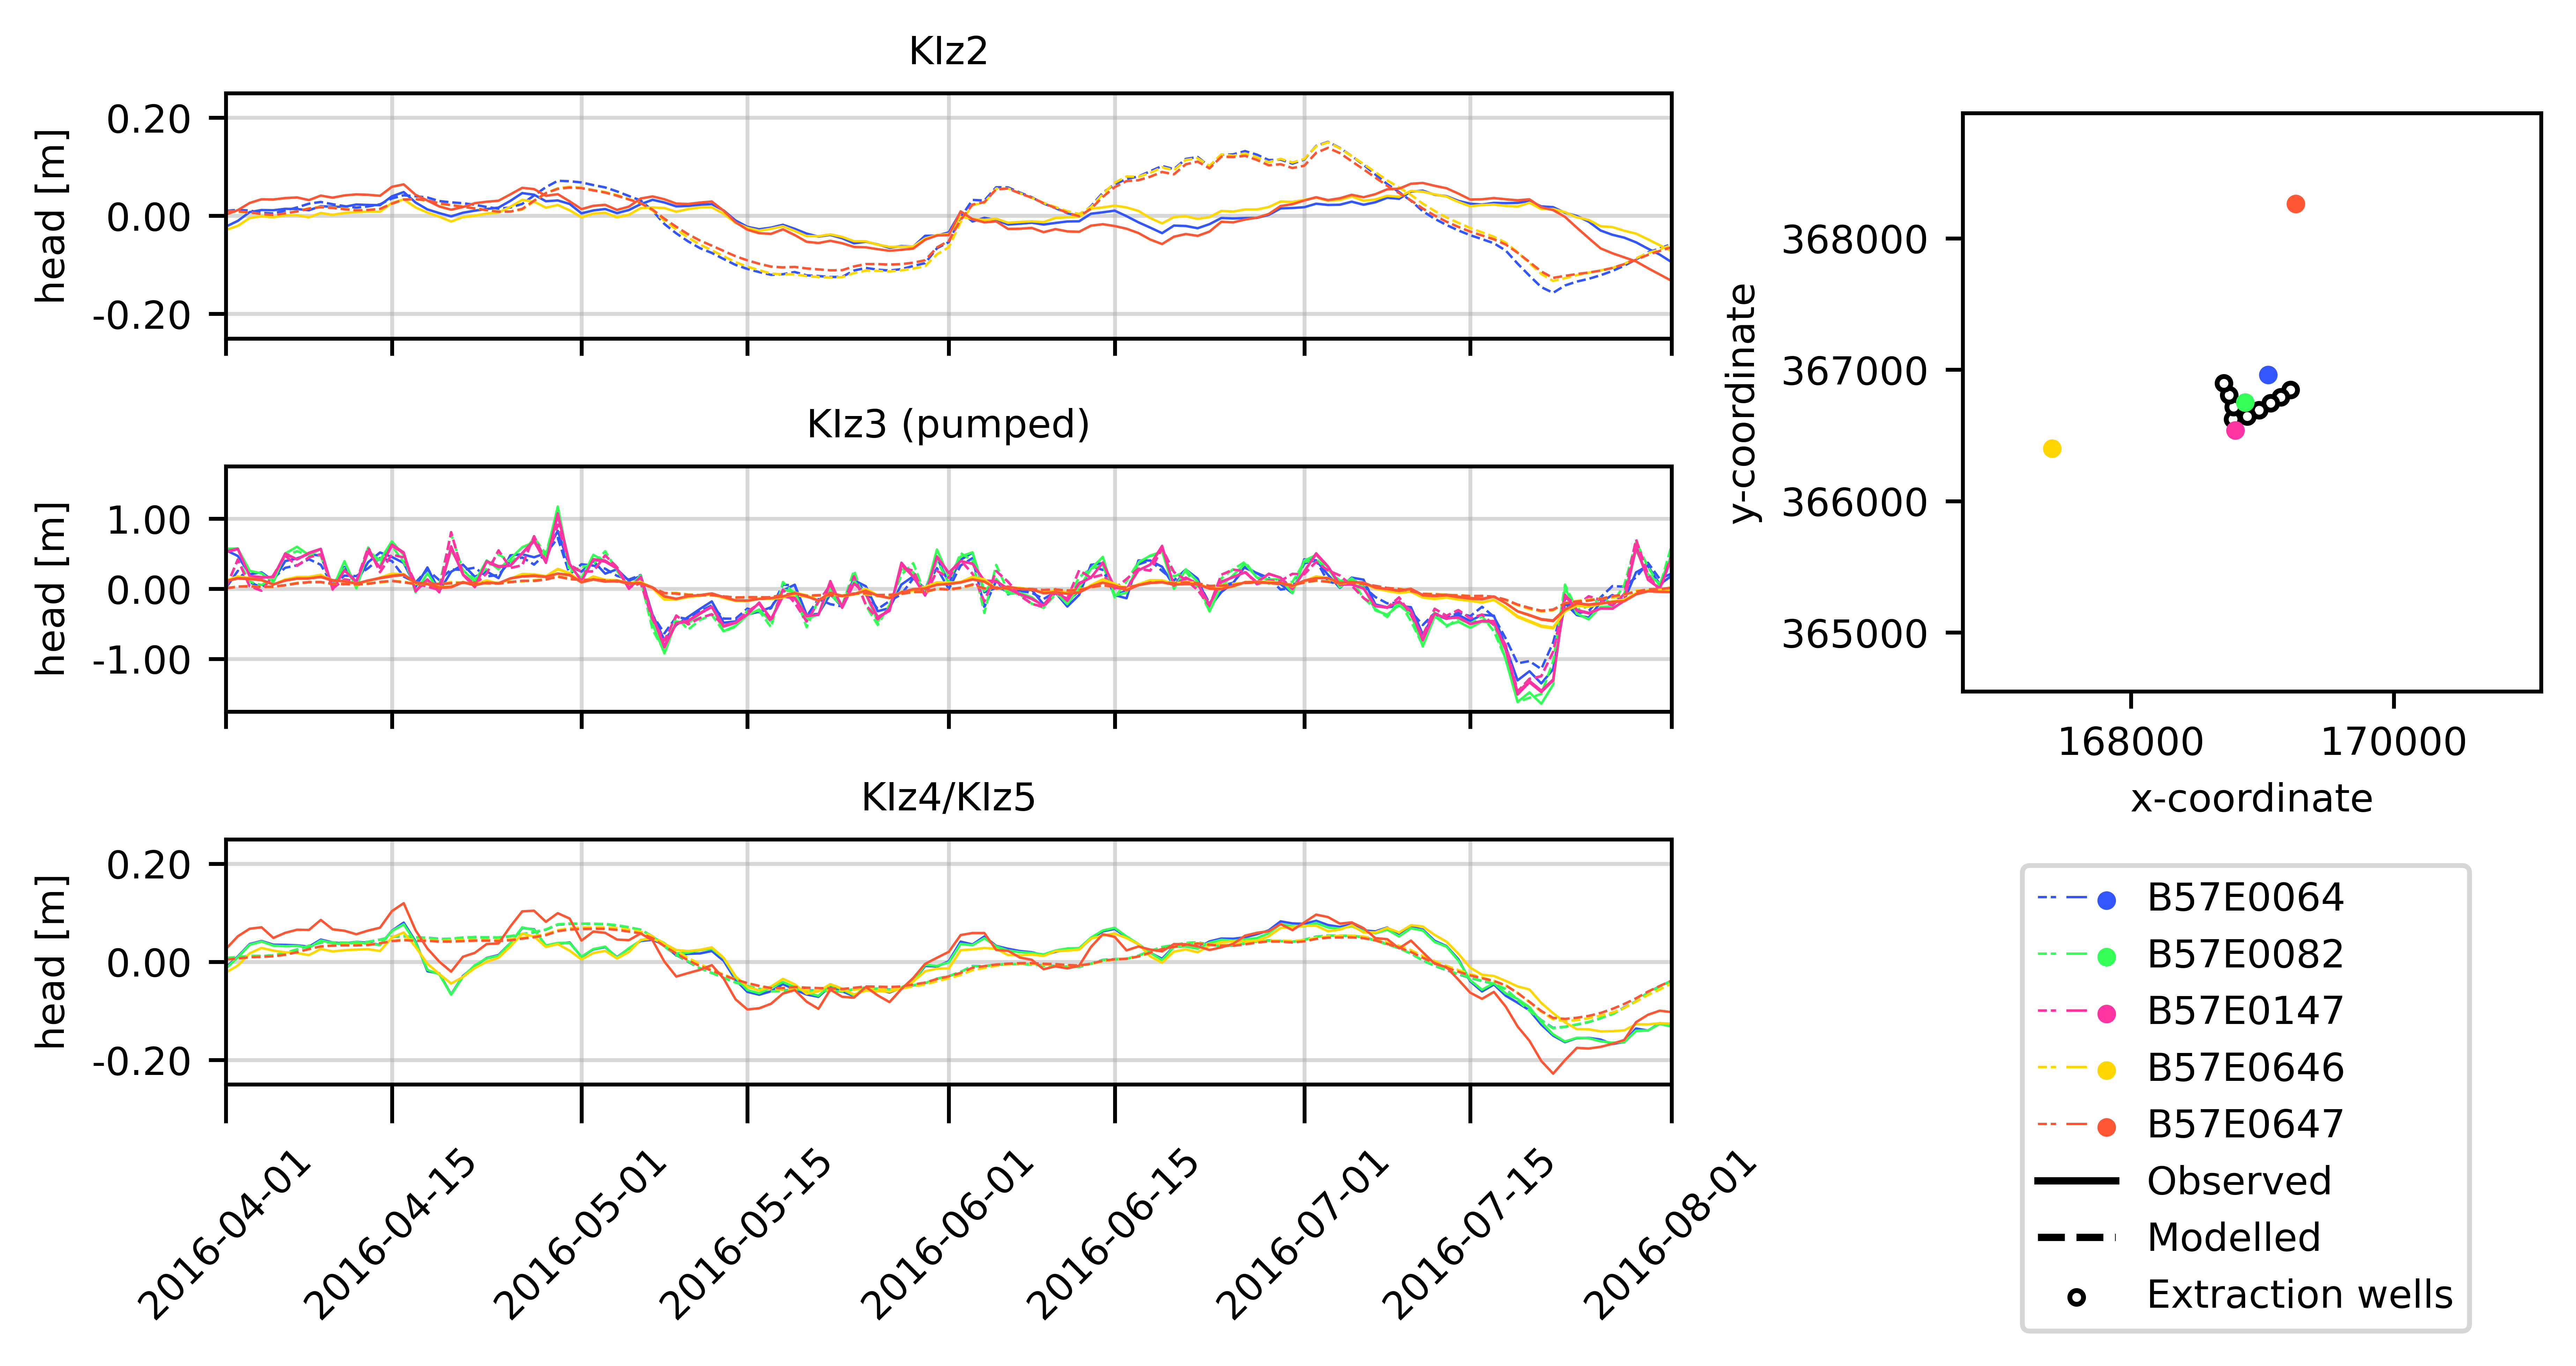

In [172]:
import matplotlib.gridspec as gridspec



dpi = 1000
pix1 = 3.543
pix2 = 7.480
fig = plt.figure(dpi = 1000)
fig.set_size_inches(pix2,4)

id = 0
lays =ObsWells.Layno.unique()
boreholes = list(set([col.split('_')[0] for col in ObsWells.putcode]))
c = {'B57E0647':'#FF5733', 
     'B57E0082': '#33FF57', 
     'B57E0064': '#3357FF', 
     'B57E0147': '#FF33A1', 
     'B57E0646': '#FFD700',}
gs = gridspec.GridSpec(3, 2, width_ratios=[2.5, 1])
axs = []

legendaxis = []
for idx, lay in enumerate(lays[:-1]):
    dfsel = ModHeads[ObsWells[ObsWells['Layno'] == lay].putcode]
    obssel = ObsHeads[ObsWells[ObsWells['Layno'] == lay].putcode]
    axs.append(plt.subplot(gs[idx,0]))
    ax = axs[idx]
    for no,col in enumerate(dfsel.columns):

        if idx == 0: 
            label = 'KIz2'
            ax.set_xticklabels([])
        elif idx == 1: 
            label = 'KIz3 (pumped)' 
            ax.set_xticklabels([])
        elif idx == 2 :label = 'KIz4/KIz5'

        ax.plot(dfsel.index, dfsel[col] - dfsel[col].mean(), label=col.split('_')[0] + ' (mod)', linewidth = 0.5, ls = '--', c = c[col.split('_')[0]])
        ax.plot(obssel.index, obssel[col] - obssel[col].mean(), label=col.split('_')[0] + ' (obs)', linewidth = 0.5, c = c[col.split('_')[0]])
        ax.set_title(label, fontsize = 8)
        id+=1
 
        ax.tick_params(axis='y', labelsize = 8)
        ax.set_ylabel('head [m]', size = 8)
        ax.grid(which = 'both', alpha = 0.5)
        ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.2f'))
        ax.set_xlim(ModHeads.index[0], ModHeads.index[-1])
        adj = 0.2 if idx == 1 else 0.1
        lim = 1.75 if idx == 1 else 0.25
        ax.set_ylim(-lim, lim)
        # ax.set_ylim(min(dfsel[col]- dfsel[col].mean())-adj, max(dfsel[col]- dfsel[col].mean())+adj)
        # if no != 0:
        #     ax.sharey(axes.ravel()[id - no])
    legendaxis.append(ax)
ax.tick_params(axis='x', labelrotation=45, labelsize = 8, size = 8)
lines_labels =[ax.get_legend_handles_labels() for ax in legendaxis]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
unique_labels_handles = {label: lines for lines, label in zip(lines, labels)}
sorted_labels_handles = sorted(unique_labels_handles.items())
labels, lines = zip(*sorted_labels_handles)



s = 8
marker = 'o'
ax = plt.subplot(gs[0:2,1])
ax.scatter(x = ExWells.x_coordinaat, y = ExWells.y_coordinaat, label = 'Extraction wells', s=s, marker = marker, zorder =2, color=  'white', ec = 'black', linewidths= 1)

# ax.scatter(boringen.metadata.loc['X-coordinaat (m)'].astype('float'), boringen.metadata.loc['Y-coordinaat (m)'].astype('float'), ec = 'black',fc = 'none', label = 'Boreholes', s=s,zorder = 4, marker = 'o')
ax.set_xlim(ds.extent[0]+1000, ds.extent[1]-1000)
ax.set_ylim(ds.extent[2]+1000, ds.extent[3]-1000)

codes = []
for idx, row in ObsWells.iterrows():
    code = row.putcode.split('_')[0]
    if code not in codes:
        ax.scatter(row.x_coordinaat, row.y_coordinaat, label = code, s=s, marker = marker, zorder = 3, color=  c[code])
        # ax.annotate(code, (row.x_coordinaat+50, row.y_coordinaat+1), fontsize = 8)
    codes.append(code)

ax.set_xlabel('x-coordinate', fontsize = 8)
ax.set_ylabel('y-coordinate', fontsize = 8)
ax.tick_params(axis='x', labelsize = 8)#,labelrotation=45)
ax.tick_params(axis='y', labelsize = 8)
ax.set_aspect('equal')


from matplotlib.legend_handler import HandlerTuple
from matplotlib.lines import Line2D
handles2, labels2 = ax.get_legend_handles_labels()
lines = list(lines) + handles2
labels = list(labels) + labels2
combolines = []
combolabels = []
for x in range(5):
    combolines.append((lines[x*2], lines[x*2+1], handles2[x+1]))
    combolabels.append(labels2[x+1])

combolines.append(Line2D([0], [0], color='black', linestyle='-'))
combolines.append(Line2D([0], [0], color='black', linestyle='--'))
combolines.append(handles2[0])
combolabels.append('Observed')
combolabels.append('Modelled')
combolabels.append(labels2[0])
fig.legend(combolines, combolabels, fontsize = 8, ncol = 1, loc = 'lower right', handler_map={tuple: HandlerTuple(ndivide=3, pad = 0.3)}, bbox_to_anchor = (0.96, 0.02))
fig.tight_layout()
fig.savefig('../Images/Figure_3.pdf')

Plot RMSE vs KGE

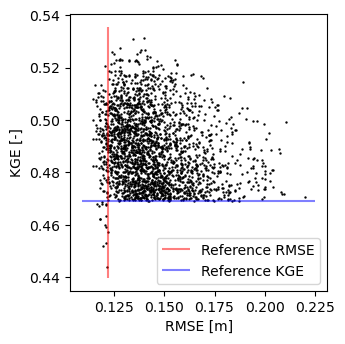

In [177]:

sel = best.sel(icell2d = 0)
resultsBetter = sel.to_dataframe()
# resultsBetter = resultsBetter[resultsBetter.RMSE < RMSE_ref]
# best = best.where(best.RMSE < RMSE_ref)
fig, ax = plt.subplots()
fig.set_size_inches(pix1, pix1)

s = resultsBetter.plot.scatter(x = 'RMSE', y = 'KGE', s = 0.5,ax = ax, color = 'black')
ymin, ymax = s.get_ylim()
xmin,xmax = s.get_xlim()
ax.vlines(RMSE_ref, ymin = ymin, ymax = ymax, zorder =  5, alpha = 0.5, color = 'red', label = 'Reference RMSE')
ax.hlines(KGE_ref, xmin = xmin, xmax = xmax, zorder =  5, alpha = 0.5, color = 'blue', label = 'Reference KGE')
ax.legend()
ax.set_xlabel('RMSE [m]')
ax.set_ylabel('KGE [-]')
fig.tight_layout()
fig.savefig('../Images/Figure_4.pdf')

In [133]:
results[['RMSE','xcorlen','zcorlen', 'frac', 'cc']].corr()

RMSE       xcorlen       zcorlen          frac            cc
RMSE     1.000000  2.850155e-01 -3.473998e-01  1.777551e-01 -4.928586e-01
xcorlen  0.285016  1.000000e+00 -6.066958e-15  5.333640e-16 -6.510541e-17
zcorlen -0.347400 -6.066958e-15  1.000000e+00  7.918710e-17 -1.389822e-16
frac     0.177755  5.333640e-16  7.918710e-17  1.000000e+00  1.639546e-16
cc      -0.492859 -6.510541e-17 -1.389822e-16  1.639546e-16  1.000000e+00

Plot correlation lengths vs eachother

In [178]:
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
def plot_2dhist(results,resultsBetter, col1, col2,axs, letter = None):
    dc = {'xcorlen' : '$L_x$ [m]', 
          'zcorlen' : '$L_z$ [m]',
          'cc' : '$K_{core}$ adjustment [log K]', 
          'frac' : 'Clay fraction adjustment'}
    fulldf = results[[col1, col2]].value_counts().reset_index(name='count')
    fulldf['count'] = 0

    df = resultsBetter[[col1, col2]].value_counts().reset_index(name='count')

    norm = plt.Normalize(0, df['count'].max())
    sc = sns.scatterplot(fulldf,x = col1, y = col2, ax = axs, edgecolor = 'black', facecolors = 'none', s = 100)
    sns.scatterplot(df,x = col1, y = col2, hue = 'count', ax = axs,hue_norm = norm, palette = 'viridis', s= 100, edgecolor = 'black')
    sm = plt.cm.ScalarMappable(cmap="viridis", norm=norm)
    sm.set_array([])
    divider = make_axes_locatable(axs)
    cax = divider.append_axes('right', size='5%', pad=0.05)

    axs.get_legend().remove()
    cbar = axs.figure.colorbar(sm, cax = cax)
    cbar.ax.tick_params(labelsize=10) 
    cbar.ax.set_ylabel('Frequency', fontsize = 10 )
    axs.tick_params(labelsize = 10)
    axs.set_xlabel(dc[col1], fontsize = 10)
    axs.set_ylabel(dc[col2], fontsize = 10)
    axs.set_title(letter, fontsize = 10)
    return axs
# resultsBetter = resultsBetter[resultsBetter.RMSE < RMSE_ref]
fig, axs = plt.subplots(3,2, dpi = 1200)
fig.set_size_inches(pix2,8)
plot_2dhist(results,resultsBetter, 'xcorlen', 'cc', axs[0,0], 'A')
plot_2dhist(results, resultsBetter,'xcorlen', 'zcorlen', axs[1,0], 'C')
plot_2dhist(results, resultsBetter,'xcorlen', 'frac', axs[0,1] ,'B')
plot_2dhist(results, resultsBetter,'cc', 'frac', axs[1,1] ,'D')
plot_2dhist(results, resultsBetter,'cc', 'zcorlen', axs[2,0] ,'E')
plot_2dhist(results, resultsBetter,'frac', 'zcorlen', axs[2,1] ,'F')

axs[0,1].set_yticks([-0.05, 0.0, 0.05])
axs[1,1].set_yticks([-0.05, 0.0, 0.05])
axs[2,1].set_xticks([-0.05, 0.0, 0.05])

fig.tight_layout()
fig.savefig('../Images/Figure_6.pdf')



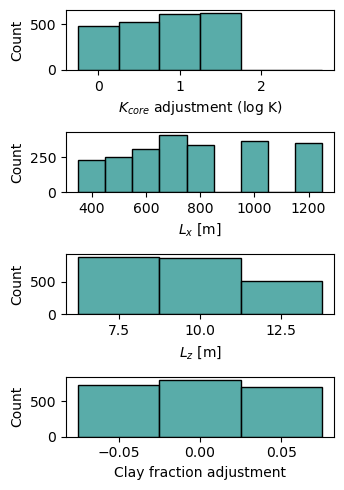

In [179]:
fig, ax = plt.subplots(4)
fig.set_size_inches(pix1,5)

import matplotlib as mpl
cm = mpl.colormaps.get_cmap('viridis')
histdf = resultsBetter
bins_cc = [-0.25, 0.25, 0.75, 1.25, 1.75, 2.25, 2.75]
bins_xcorlen = [350, 450, 550, 650, 750, 850, 950, 1050, 1150, 1250]
bins_zcorlen = bin_edges = [6.25, 8.75, 11.25, 13.75]
bins_frac = [-0.075, -0.025, 0.025, 0.075]

sns.histplot(histdf, x = 'cc', ax = ax[0], color= cm(0.5), bins = bins_cc)
sns.histplot(histdf, x = 'xcorlen', ax = ax[1],  color= cm(0.5), bins = bins_xcorlen)
sns.histplot(histdf, x = 'zcorlen', ax = ax[2],  color= cm(0.5), bins = bins_zcorlen)
sns.histplot(histdf, x = 'frac', ax = ax[3],  color= cm(0.5), bins = bins_frac,)

ax[0].set_xlabel('$K_{core}$ adjustment (log K)')
ax[1].set_xlabel('$L_x$ [m]')
ax[2].set_xlabel('$L_z$ [m]')
ax[3].set_xlabel('Clay fraction adjustment')
ax[2].set_xticks([7.5, 10, 12.5])
fig.tight_layout()
fig.savefig('../Images/Figure_5.pdf')

In [138]:
# best.frac.min()
def reduce_constant_variables(ds):
    reduced_ds = ds.copy()  # Work on a copy of the dataset
    
    for var in ds.data_vars:
            # Check if the variable has the same value along this dimension
            if var != 'k':
                reduced_ds[var] = reduced_ds[var].mean(dim = 'icell2d')
    
    return reduced_ds
best = reduce_constant_variables(best)


Iteration with smallest change: 11
11


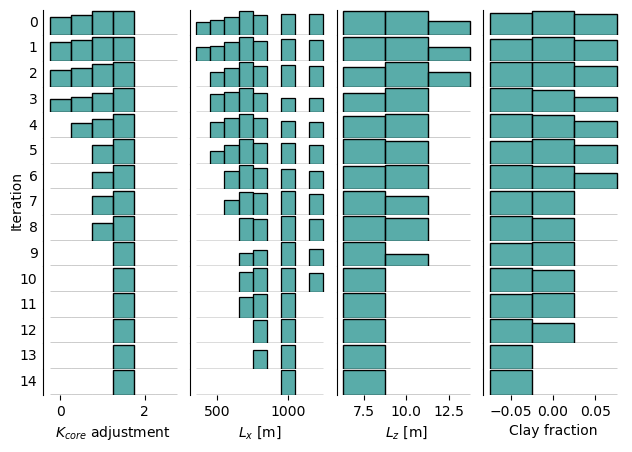

In [180]:
def makefig(ds, ax, it, bins, its):
    histdf = ds#[['cc', 'xcorlen', 'zcorlen', 'frac']].to_dataframe().astype('string')
    sns.histplot(histdf, x = 'cc', ax = ax[it,0], color= cm(0.5), bins =bins[0])
    sns.histplot(histdf, x = 'xcorlen', ax = ax[it,1], color= cm(0.5), bins = bins[1])
    sns.histplot(histdf, x = 'zcorlen', ax = ax[it,2],  color= cm(0.5), bins = bins[2])
    sns.histplot(histdf, x = 'frac', ax = ax[it,3],  color= cm(0.5), bins = bins[3])

    ax[it,0].set_xlabel('$K_{core}$ adjustment')
    ax[it,1].set_xlabel('$L_x$ [m]')
    ax[it,2].set_xlabel('$L_z$ [m]')
    ax[it,3].set_xlabel('Clay fraction')
    ax[it,2].set_xticks([7.5, 10.0, 12.5])
    
    for no1 in range(4):
        for no2 in range(its+1):
            if no2 != its:
                ax[no2,no1].set_xlabel('')
                ax[no2,no1].set_xticklabels('')
                ax[no2,no1].set_xticks([])

            if no1 != 0:
                ax[no2,no1].set_yticks([])
            ax[no2,no1].set_yticklabels('')
    return ax 

def prune(ds, it, minit, mintotal):
    cols = ['cc','xcorlen', 'zcorlen', 'frac']
    min = 1
    for col in cols:
        counts = ds[col].to_dataframe().value_counts()
        if  counts.min()/max(counts) < min:
            min = counts.min()/max(counts)
            mincol = col
            mincounts = counts.copy()
            minval = mincounts[mincounts == counts.min()].index[0]
    if min > mintotal:
        mintotal = min
        minit = it
    ds = ds.where(ds[mincol] != minval, drop = False)
    return ds, minit, mintotal
            
bestopt_temp = best.copy(deep = True)
its = 14

fig, ax = plt.subplots(its+1,4, sharey = False)
fig.set_size_inches(pix2,5)
bins_cc = [-0.25, 0.25, 0.75, 1.25, 1.75, 2.25, 2.75]
bins_xcorlen = [350, 450, 550, 650, 750, 850, 950, 1050, 1150, 1250]
bins_zcorlen = bin_edges = [6.25, 8.75, 11.25, 13.75]
bins_frac = [-0.075, -0.025, 0.025, 0.075]
bins = [bins_cc, bins_xcorlen, bins_zcorlen, bins_frac]
ax = makefig(bestopt_temp, ax, 0, bins, its)
minit = 0
mintotal = 0
for it in range(its):
    bestopt_temp, minit, mintotal = prune(bestopt_temp, it, minit, mintotal)
    ax = makefig(bestopt_temp, ax, it+1, bins, its)
fig.subplots_adjust(hspace=0.0, wspace = 0.05)
for x in range(its+1):
        ax[x,0].set_ylabel(x, rotation = 0, fontsize = 10, va = 'center', ha = 'right')
        for y in range(1,4):
            ax[x,y].set_ylabel('')
        for y in range(4):
            ax[x,y].spines['top'].set_visible(False)
            ax[x,y].spines['right'].set_visible(False)
            # ax[x,y].spines['left'].set_visible(False)
            ax[x,y].spines['bottom'].set_visible(False)
            ax[x,y].set_yticks([])
fig.text(0.09, 0.5, 'Iteration', ha='center', va='center', rotation='vertical')
fig.savefig('../Images/Figure_7.pdf')
print(f'Iteration with smallest change: {minit}')

bestopt_nans = best.copy(deep = True)
minit2 = 0
mintotal2 = 0
for it in range(minit):
    bestopt_nans, minit2, mintotal2 = prune(bestopt_nans, it, minit2, mintotal2)
bestopt = bestopt_nans.dropna(dim = 'index')
print(len(bestopt))


loading simulation...
  loading simulation name file...
  loading tdis package...
  loading model gwf6...
    loading package disv...
    loading package npf...
    loading package ic...
    loading package wel...
    loading package ghb...
    loading package drn...
    loading package oc...
  loading solution package vlen_ss...


C:\Users\leermdv\AppData\Local\Temp\ipykernel_26780\3030229334.py:86: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


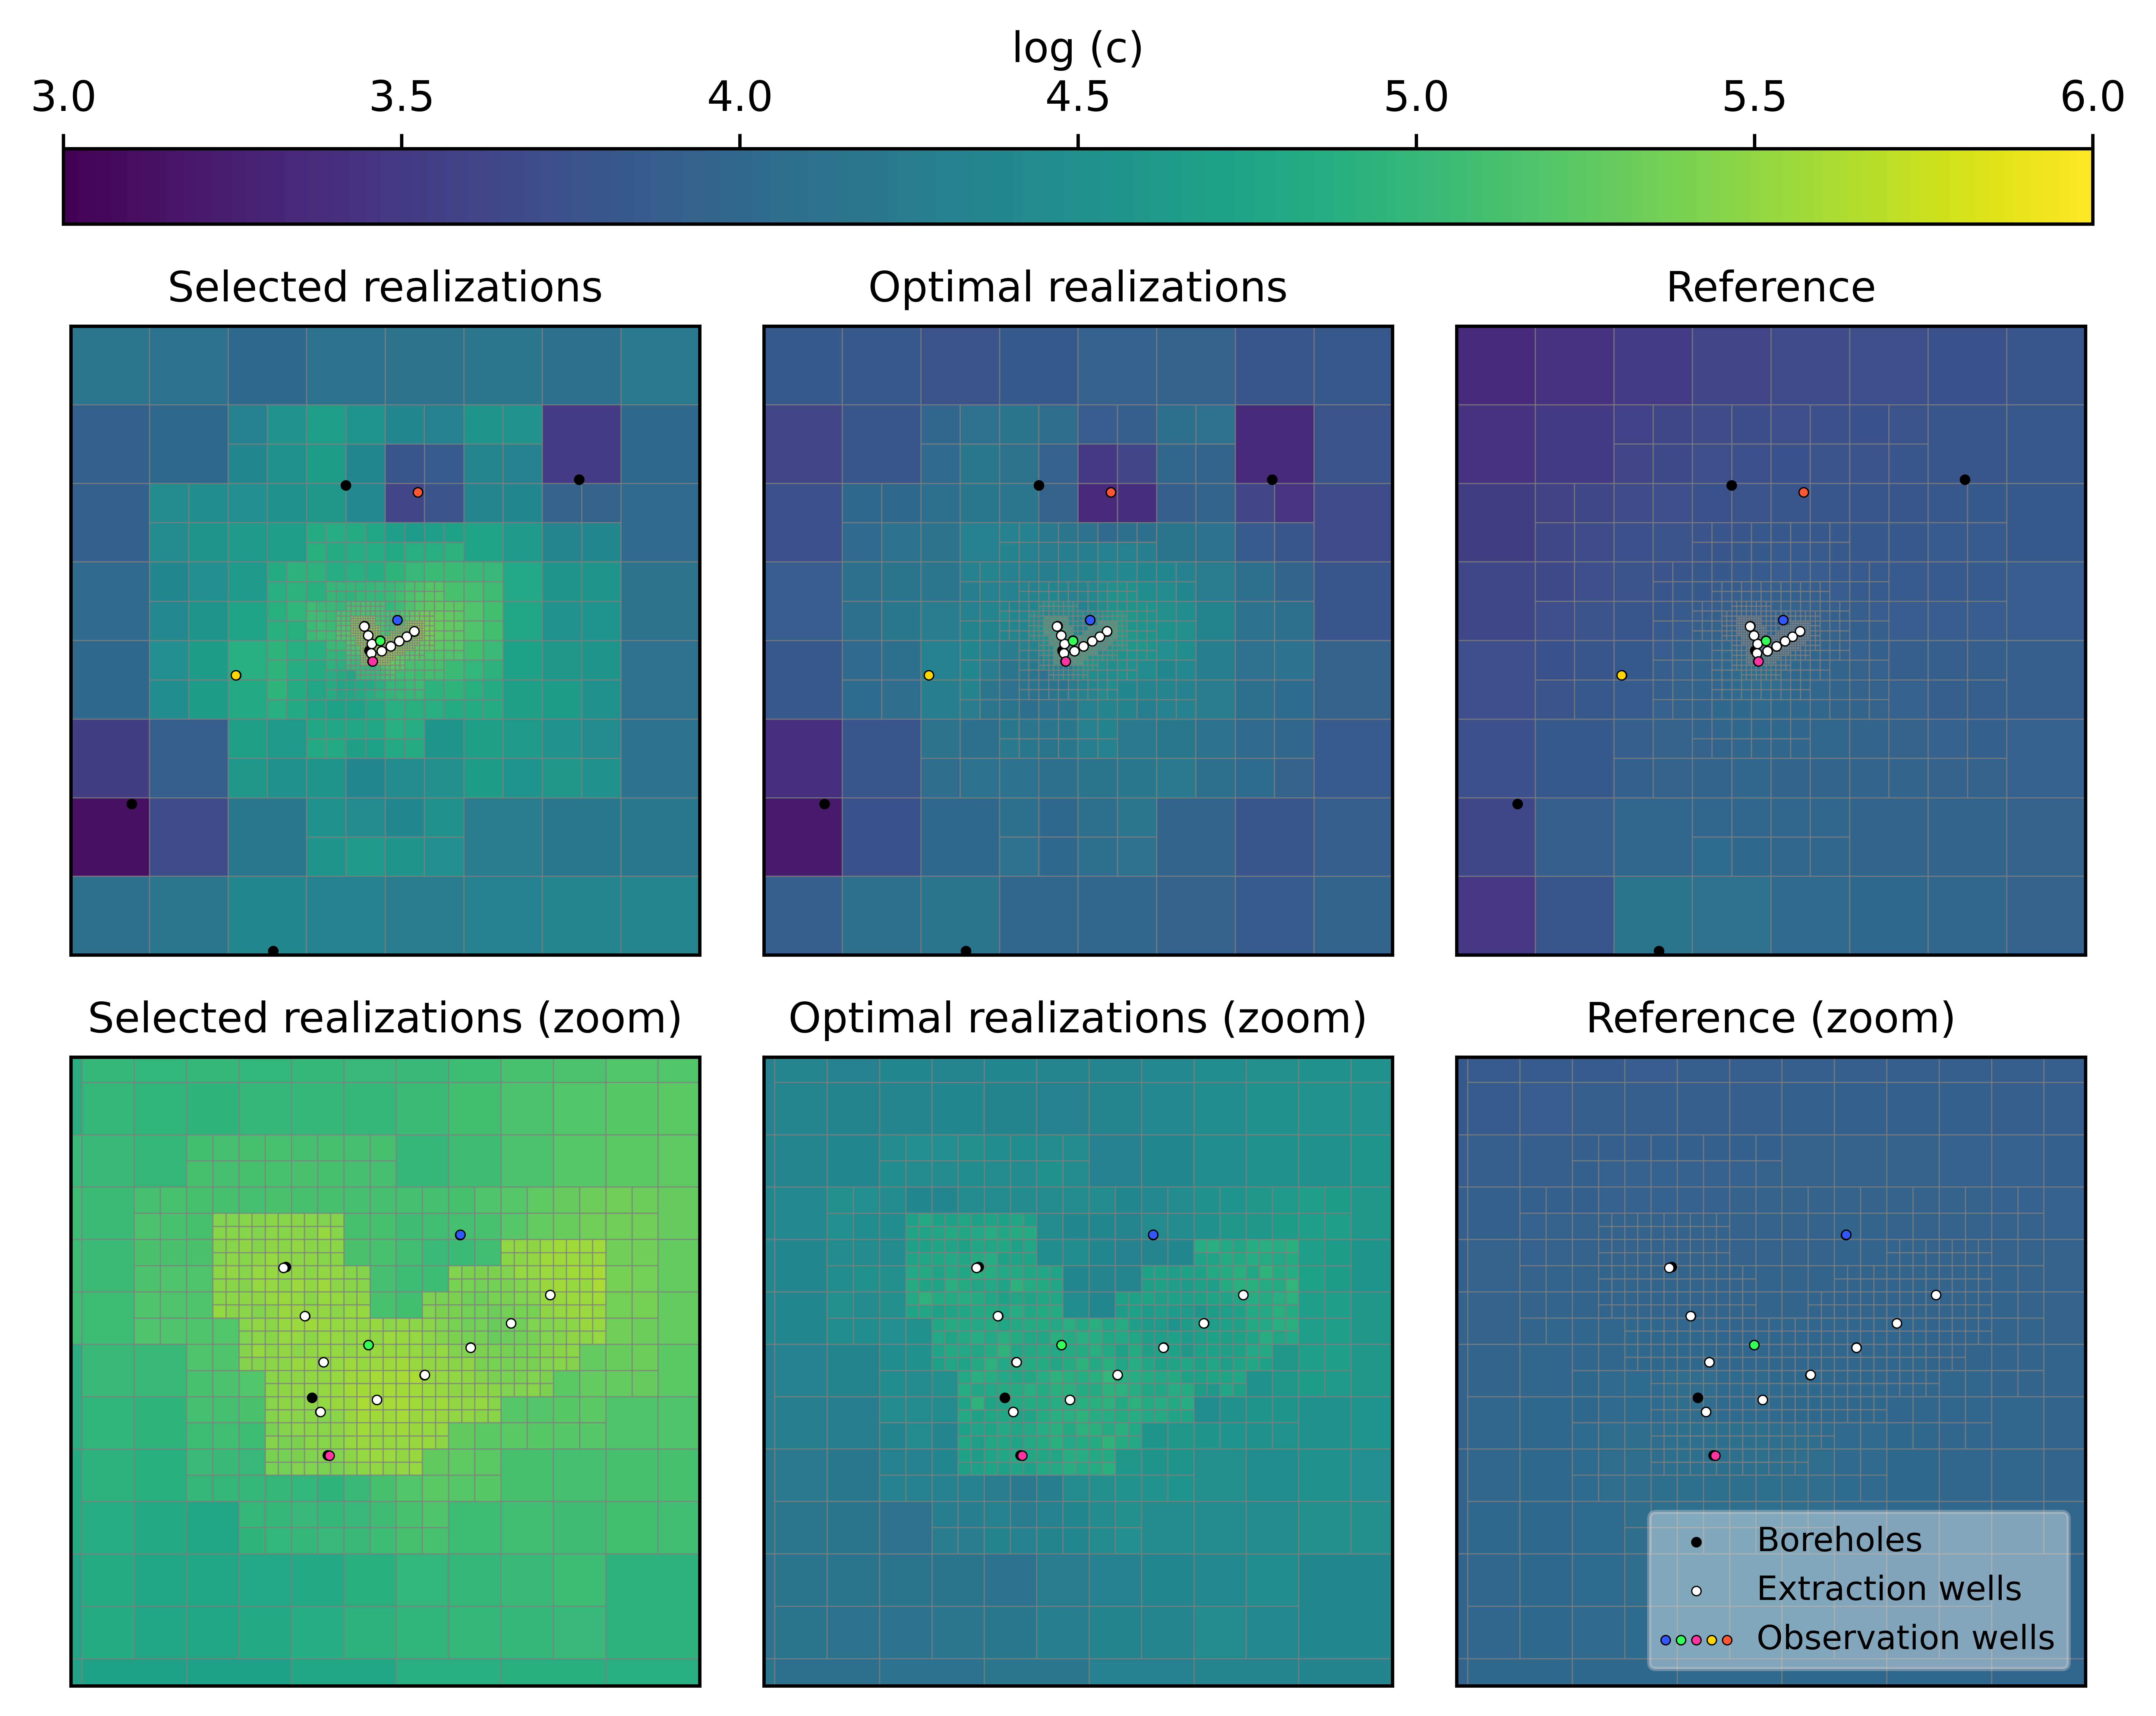

In [313]:
import nlmod
import xarray as xr

import pickle
sim = flopy.mf6.MFSimulation.load('mfsim', sim_ws = '../Results/Budel Output/Vlen/Vlen_ss')
gwf = sim.get_model()


fig, axs = plt.subplots(2,3,dpi = 1000)
fig.set_size_inches(pix2,5)

def geometric_mean(values):
    return np.exp(np.log(values).mean())

geo_mean = xr.apply_ufunc(geometric_mean, best, input_core_dims =[['index']], vectorize = True)
geo_mean_opt = xr.apply_ufunc(geometric_mean, bestopt, input_core_dims =[['index']], vectorize = True)
ds['meanbestKV'] = geo_mean.k
ds['meanbestKV_opt'] = geo_mean_opt.k

d =  -(ds.isel(layer = list(ds.layer).index('KIk2')).botm - ds.isel(layer = list(ds.layer).index('KIk2') -1).botm)
c = d/(ds.sel(layer = 'KIk2').kv * Params.loc['KIk2'].values)
vmin = 3
vmax = 6
norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
sm = mpl.cm.ScalarMappable(cmap='viridis', norm=norm)
pmvs = []
for ax in axs.ravel():
    pmvs.append(flopy.plot.PlotMapView(gwf, ax = ax))

pmvs[0].plot_array(np.log10(ds.meanbestKV), vmin = vmin, vmax = vmax)
pmvs[3].plot_array(np.log10(ds.meanbestKV), vmin = vmin, vmax = vmax)
pmvs[1].plot_array(np.log10(ds.meanbestKV_opt), vmin = vmin, vmax = vmax)
pmvs[4].plot_array(np.log10(ds.meanbestKV_opt), vmin = vmin, vmax = vmax)
pmvs[2].plot_array(np.log10(c), vmin = vmin, vmax = vmax)
pmvs[5].plot_array(np.log10(c), vmin = vmin, vmax = vmax)
for pmv in pmvs:
    pmv.plot_grid(linewidth = 0.3, alpha = 0.5)

cbar_ax = fig.add_axes([0.05, 1, 0.9, 0.05])
cbar = fig.colorbar(sm, cax=cbar_ax, orientation='horizontal')
cbar.set_label('log (c)', )
cbar.ax.xaxis.set_ticks_position('top')
cbar.ax.xaxis.set_label_position('top')
fig.subplots_adjust(right=0.95,left = 0.05,bottom = 0.2, hspace=0.2, wspace=0.2)
c = {'B57E0647':'#FF5733', 
     'B57E0082': '#33FF57', 
     'B57E0064': '#3357FF', 
     'B57E0147': '#FF33A1', 
     'B57E0646': '#FFD700',}
for x in [0,1]:
    for y in [0,1,2]:
        axs[x,y].scatter(boringen.metadata.loc['X-coordinaat (m)'].astype('float'), boringen.metadata.loc['Y-coordinaat (m)'].astype('float'),color = 'black', linewidth = 0.3,label = 'Boreholes', s=5, zorder =9)
        sns.scatterplot(ExWells,  x='x_coordinaat', y = 'y_coordinaat', ax = axs[x,y], c = 'white', s = 5,ec = 'black', linewidth = 0.3, label = 'Extraction wells',zorder = 10)
        codes = []
        for idx, row in ObsWells.iterrows():
            code = row.putcode.split('_')[0]
            if code not in codes:
                axs[x,y].scatter(row.x_coordinaat, row.y_coordinaat, label = code, s=5, marker = marker, ec = 'black', linewidth = 0.3, zorder = 11, color=  c[code])
                # ax.annotate(code, (row.x_coordinaat+50, row.y_coordinaat+1), fontsize = 8)
            codes.append(code)
        axs[x,y].set_xticks([])
        axs[x,y].set_yticks([])
        axs[x,y].set_ylabel('')
        axs[x,y].set_xlabel('')
        axs[x,y].set_aspect('equal')
        axs[1,y].set_xlim([168300, 169500])
        axs[1,y].set_ylim([366100, 367300])
        axs[x,y].title.set_size(10)
        axs[x,y].legend().set_visible(False)

handles2, labels2 = axs[0,0].get_legend_handles_labels()
handles = [handles2[0], handles2[1], tuple(handles2[2:])]
labels = [labels2[0], labels2[1], 'Observation wells']
axs[-1,-1].legend(handles, labels, fontsize = 8, framealpha = 0.4, loc = 'lower right', handler_map={tuple: HandlerTuple(ndivide=5, pad = 0.3)})
        

axs[0,0].set_title("Selected realizations", fontsize = 10)
axs[1,0].set_title("Selected realizations (zoom)",fontsize = 10)

axs[0,1].set_title("Optimal realizations", fontsize = 10)
axs[1,1].set_title("Optimal realizations (zoom)",fontsize = 10)

axs[0,2].set_title("Reference", fontsize = 10)
axs[1,2].set_title("Reference (zoom)",fontsize = 10)

fig.tight_layout()
fig.savefig('../Images/Figure_8.pdf')


In [300]:
handles

 (<matplotlib.collections.PathCollection at 0x2617183d290>,
  <matplotlib.collections.PathCollection at 0x2613c6e8850>)]

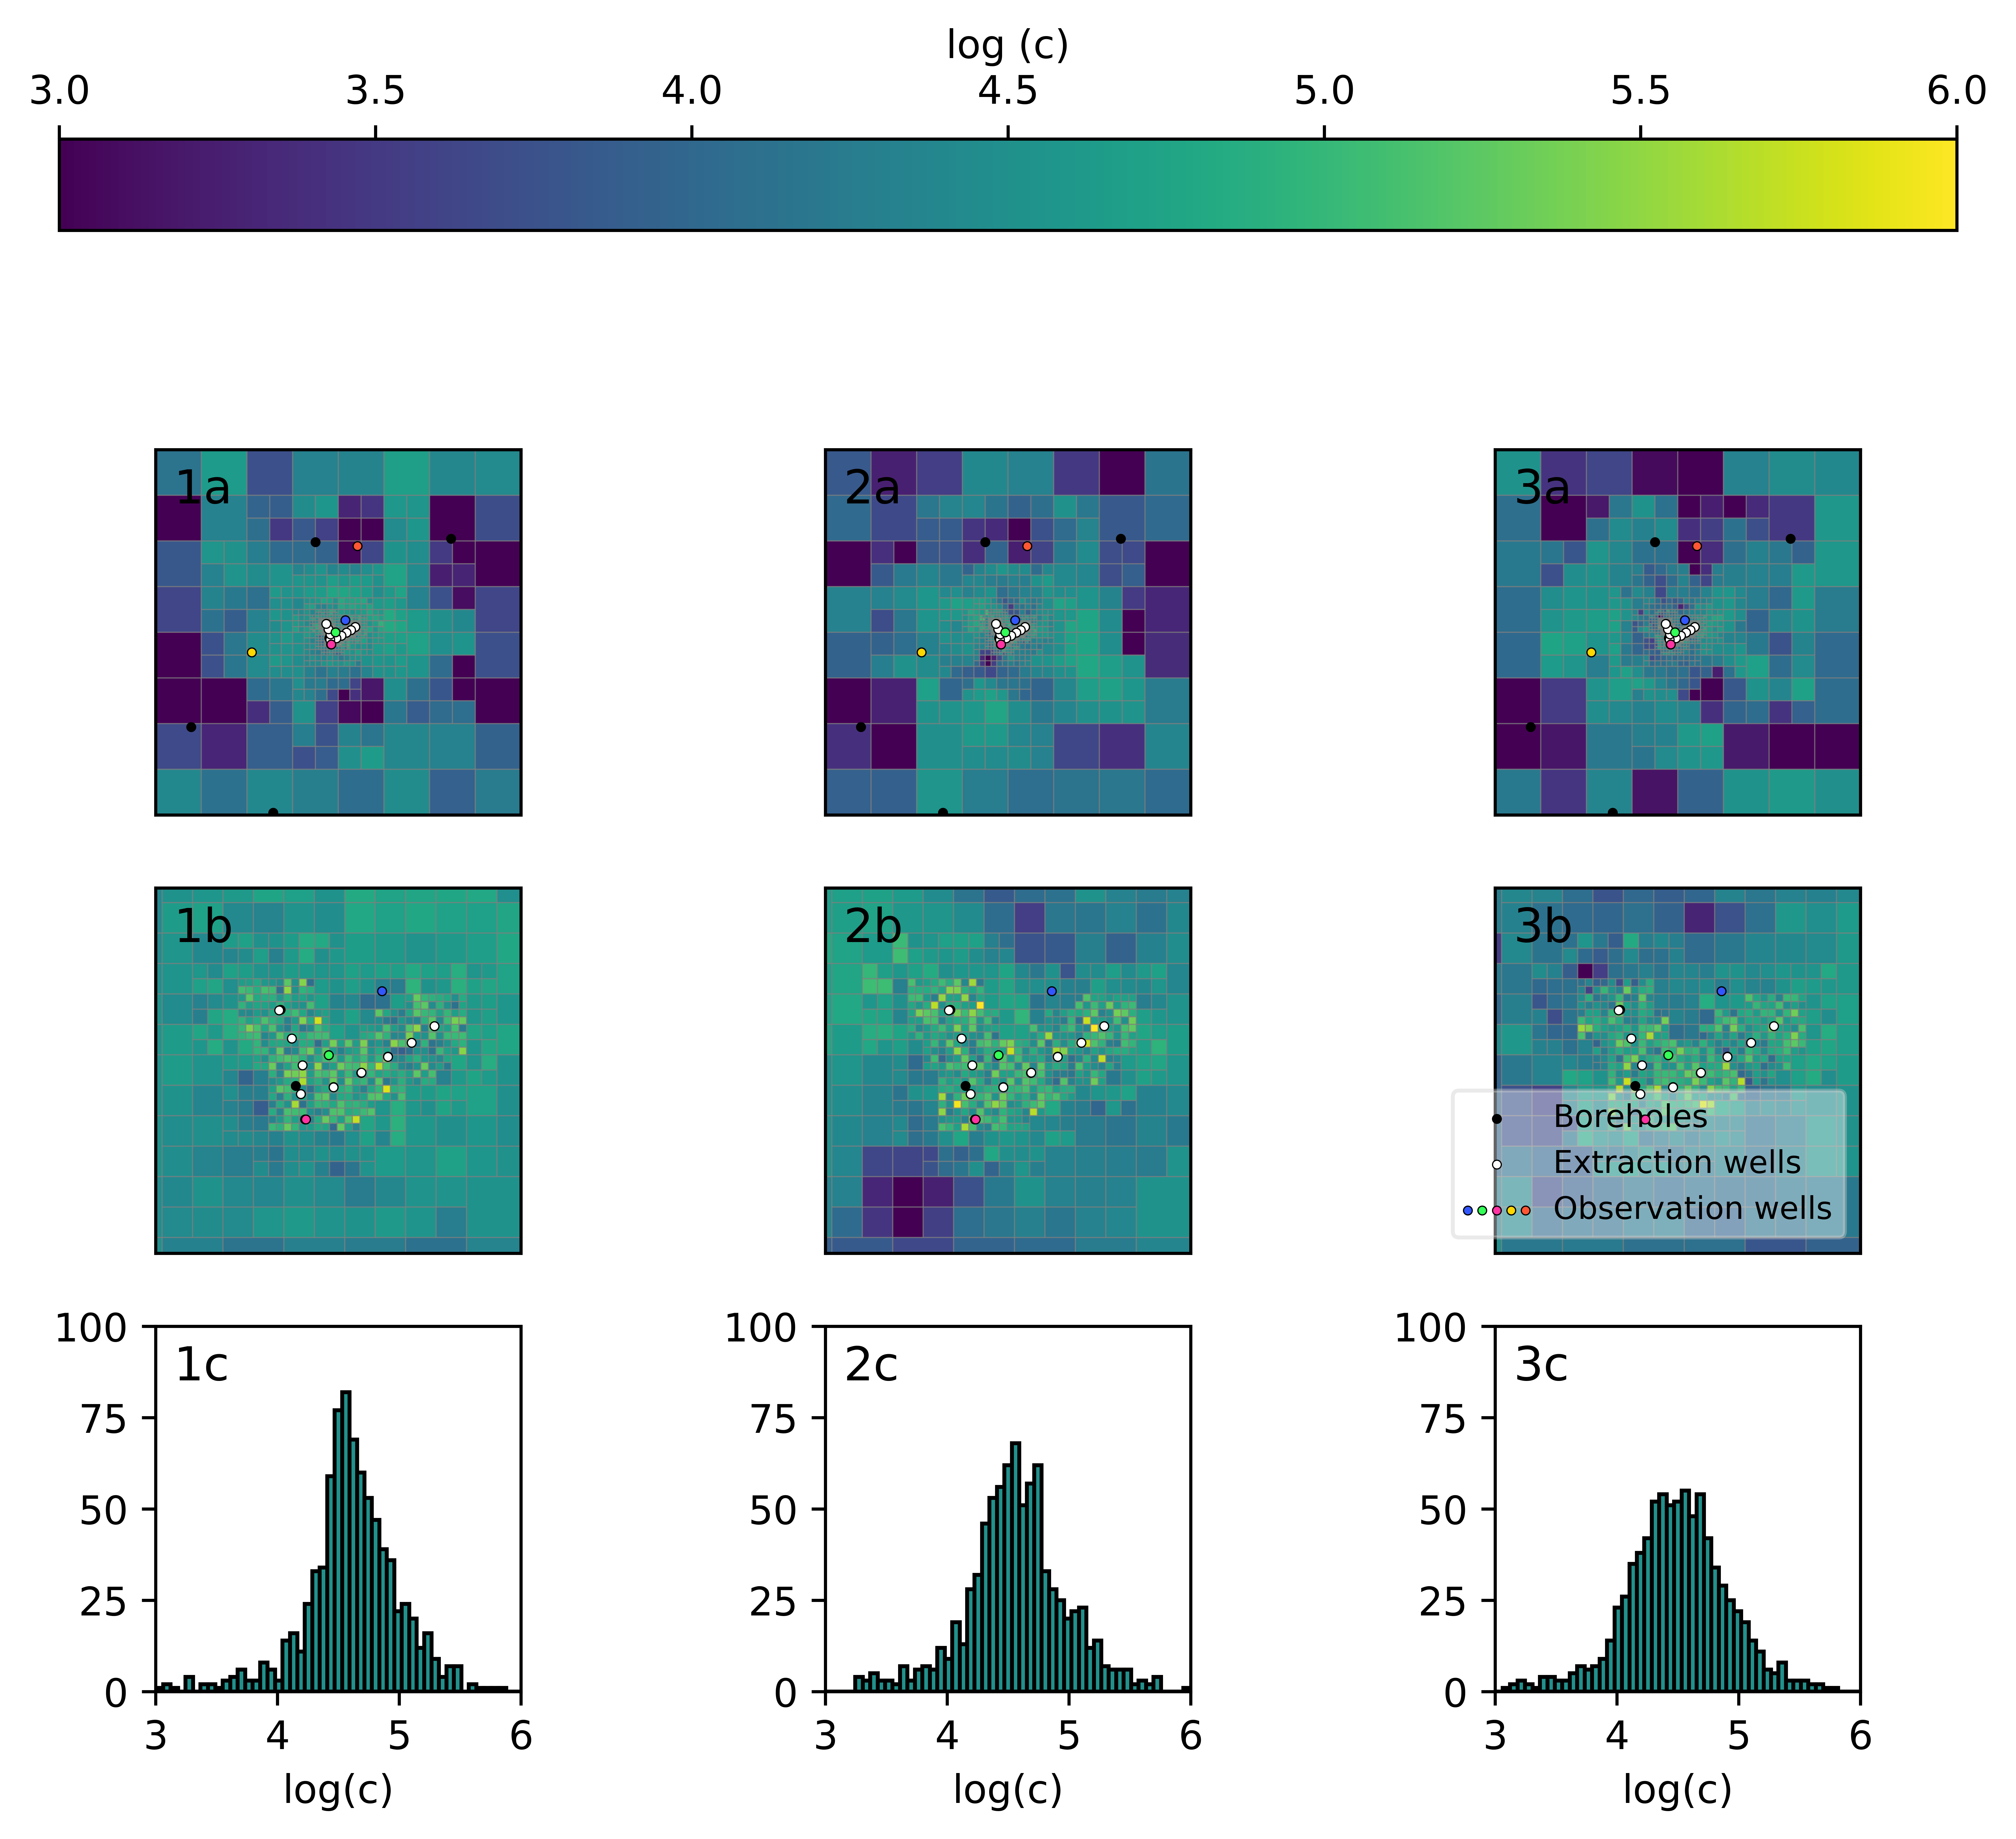

In [317]:
import nlmod
import xarray as xr
import os 

num = 3
fig, axs = plt.subplots(3,num, dpi = 1000)
fig.set_size_inches(pix2,pix2-1)


sample = bestopt.sortby('RMSE')
sample = bestopt.isel(index = slice(0,5))
vmin =3
vmax = 6
norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
sm = mpl.cm.ScalarMappable(cmap='viridis', norm=norm)

for i,x in enumerate(range(num)):
    sel = sample.isel(index = x)
    ds[x] = np.log10(sel.k)
    cb = True if i == 4 else False
    pmva = flopy.plot.PlotMapView(gwf, ax = axs[0,i])
    pmva.plot_grid(linewidth = 0.3, alpha = 0.5)
    pmvb = flopy.plot.PlotMapView(gwf, ax = axs[1,i])
    pmvb.plot_grid(linewidth = 0.3, alpha = 0.5)
    a  = pmva.plot_array(ds[x],vmin = vmin, vmax = vmax)
    b = pmvb.plot_array(ds[x],vmin = vmin, vmax = vmax)
    if i ==0:
        _,bins,_ = np.log10(sel.k).plot.hist(ax = axs[2,i], bins = np.linspace(vmin,vmax, 50),xlim = (vmin, vmax),ylim = (0, 100), edgecolor = 'black', color = cm(0.5))
    else:
        np.log10(sel.k).plot.hist(ax = axs[2,i], bins = bins,xlim = (vmin, vmax), ylim = (0, 100), edgecolor = 'black', color = cm(0.5) )
p0 = axs[0,0].get_position().get_points().flatten()
p1 = axs[0,-1].get_position().get_points().flatten()
# cbar_ax = fig.add_axes([p0[0], 1, p1[2]-p0[0], 0.05])
cbar_ax = fig.add_axes([0.05, 1, 0.9, 0.05])
cbar = fig.colorbar(sm, cax=cbar_ax, orientation='horizontal')
cbar.set_label('log (c)', )
cbar.ax.xaxis.set_ticks_position('top')
cbar.ax.xaxis.set_label_position('top')
fig.subplots_adjust(right=0.95,left = 0.05,bottom = 0.2, hspace=0.2, wspace=0.2)

alf = {0 : 'a', 1 : 'b', 2 : 'c'}
for y in range(num):
    for x in [0,1,2]:

        if x in [0,1]:
            axs[x,y].scatter(boringen.metadata.loc['X-coordinaat (m)'].astype('float'), boringen.metadata.loc['Y-coordinaat (m)'].astype('float'),facecolor = 'black', label = 'Boreholes', s=5, linewidths = 0.3,zorder = 9)
            sns.scatterplot(ExWells,  x='x_coordinaat', y = 'y_coordinaat', ax = axs[x,y], c = 'white',ec = 'black',linewidth = 0.3, s = 5, label = 'Extraction wells', zorder =  10)
            codes = []
            for idx, row in ObsWells.iterrows():
                code = row.putcode.split('_')[0]
                if code not in codes:
                    axs[x,y].scatter(row.x_coordinaat, row.y_coordinaat, label = code, s=5, marker = marker, ec = 'black', linewidth = 0.3, zorder = 11, color=  c[code])
                    # ax.annotate(code, (row.x_coordinaat+50, row.y_coordinaat+1), fontsize = 8)
                codes.append(code)
            axs[x,y].set_xticks([])
            axs[x,y].set_yticks([])
            axs[x,y].set_ylabel('')
            axs[x,y].set_xlabel('')
            axs[1,y].set_xlim([168300, 169500])
            axs[1,y].set_ylim([366100, 367300])
            axs[x,y].set_aspect('equal')
            # axs[x,y].legend(fontsize = 8, framealpha = 0.4, loc = 'lower right')
            axs[x,y].legend().set_visible(False)
        axs[x,y].set_title('')
        axs[x,y].text(0.05, 0.95, f'{y+1}{alf[x]}', transform=axs[x,y].transAxes, fontsize=12,verticalalignment='top')

    axs[2,y].set_aspect(1.0/axs[2,y].get_data_ratio(), adjustable='box')
    axs[2,y].set_xlabel('log(c)')
    sel = sample.isel(index = y)
    # p0 = axs[x,y].get_position().get_points().flatten()
    # msg = f'$L_x$: {int(sel.xcorlen.values)}m\n$L_z$: {int(sel.zcorlen.values)}m\nClay fraction: {sel.frac.values:.2f}\nCore log(K): +{int(sel.cc.values)}'
    # props = dict( facecolor='white', alpha=0.8)
    # fig.text(p0[0]+0.005,0.08,msg ,fontsize  = 8, bbox = props)
axs[1,2].legend(handles, labels, fontsize = 8, framealpha = 0.4, loc = 'lower right', handler_map={tuple: HandlerTuple(ndivide=5, pad = 0.3)})
# fig.tight_layout()
fig.savefig('../Images/Figure_9.pdf')


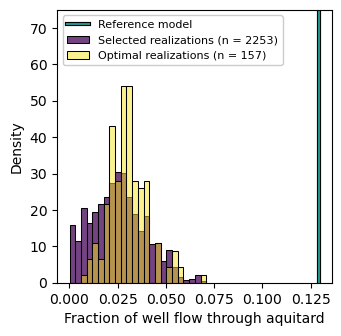

In [220]:
import seaborn as sns
import matplotlib.patheffects as pe
flowfrac = pd.read_csv(rf"C:\Users\leermdv\OneDrive - TNO\Documents\Python Scripts\ExtractionCalibrator\Results\Budel Output\{modelname}\flowfrac.csv")
dist = pd.read_csv(rf"C:\Users\leermdv\OneDrive - TNO\Documents\Python Scripts\ExtractionCalibrator\Results\Budel Output\{modelname}\TT_dist.csv")
fig, ax = plt.subplots()
fig.set_size_inches(pix1, pix1)
real = flowfrac[flowfrac.Realization == 'Realizations']
bins =  np.histogram_bin_edges(real.Flowfrac, bins = 'auto')
h = sns.histplot(data = real, x = 'Flowfrac', ax= ax, label = 'Selected realizations (n = 2253)', color = cm(0.01), bins = bins, alpha =0.75, stat = 'density')
sns.histplot(data = real[bestopt_nans.cc.values == 1.5],x = 'Flowfrac', ax= ax, label = 'Optimal realizations (n = 157)', color =cm(0.99), bins = bins, stat = 'density', alpha = 0.5)



ax.axvline(flowfrac[flowfrac.Realization == 'Reference'].Flowfrac.values[0], label = 'Reference model', color = cm(0.5),path_effects=[pe.Stroke(linewidth=3, foreground='black'), pe.Normal()])
ax.set_xlabel('Fraction of well flow through aquitard')
ax.set_ylim(0,75)
ax.legend(loc = 'upper left', fontsize = 8, framealpha = 1)
fig.savefig('../Images/Figure_10.pdf')



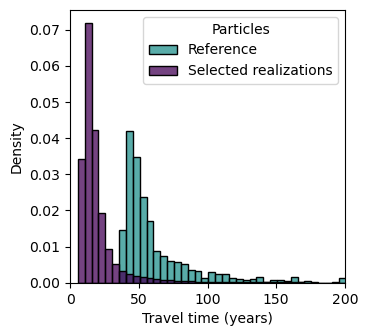

In [233]:
import seaborn as sns
import matplotlib.pyplot as plt 
dist = pd.read_csv(rf"C:\Users\leermdv\OneDrive - TNO\Documents\Python Scripts\ExtractionCalibrator\Results\Budel Output\{modelname}\TT_dist.csv")
fig, ax = plt.subplots()
fig.set_size_inches(pix1, pix1)

h = sns.histplot(data = dist, x = 'dist', hue = 'Realization', stat="density", common_norm=False, ax = ax, binwidth =5,  ec = 'black', linewidth = 1, palette = [cm(0.01), cm(0.5)], alpha = 0.75)
ax.set_xlim((0,200))
ax.set_xlabel('Travel time (years)')
ax.legend(labels = ['Reference','Selected realizations'], title = 'Particles')
fig.savefig('../Images/Figure_11.pdf')


Frac = 0.6081871345029239
[ 0.5  1.5  2.5  3.5  4.5  5.5  6.5  7.5  8.5  9.5 10.5 11.5 12.5 13.5
 14.5 15.5 16.5 17.5 18.5 19.5 20.5 21.5 22.5 23.5 24.5 25.5 26.5]


c:\ProgramData\anaconda3\envs\BW\Lib\site-packages\gstools\covmodel\plot.py:122: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


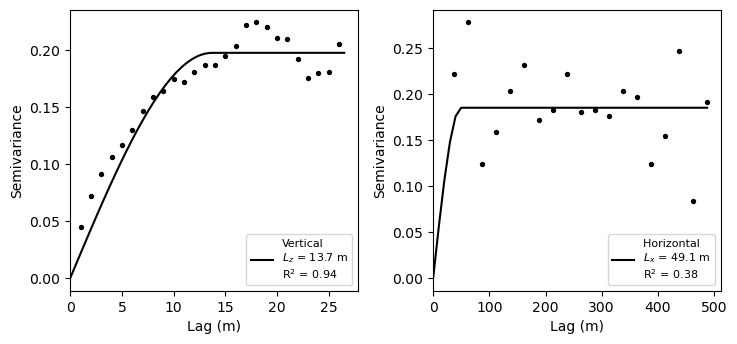

In [234]:
#%%
import gstools as gs
import pandas as pd 
import pickle
import numpy as np
import matplotlib.pyplot as plt

with open(rf"C:\Users\leermdv\OneDrive - TNO\Documents\Python Scripts\ExtractionCalibrator\Results\Budel Output\{modelname}\boreholeindicators.pkl", 'rb') as f:
    boringen = pickle.load(f)
ls = boringen.list
frac = ls.i[ls.i > 0.5].count()/len(ls)
print(f'Frac = {frac}')

model1 = gs.Spherical(dim = 3)
model3 = gs.Spherical(dim = 3)
main_axes = gs.rotated_main_axes(3,[0,0,0])
axis1, axis2, axis3 = main_axes
bins3 = np.arange(28)
kw = {'bin_no' : 20,
      'max_dist' : 500,
      }

kw_v = {'bin_no' : 27,
      'max_dist' : 27}

bin_center1, dir_vario1 = gs.vario_estimate((ls.x[::28],ls.y[::28]), ls['i (no weight)'].values.reshape(-ls.z.min(),int(len(ls.i)/-ls.z.min())),**kw)#,bins1)
bin_center3, dir_vario3 = gs.vario_estimate((ls.x,ls.y, ls.z), ls['i'], direction = axis3, **kw_v)

para, pcov, r2_1 =  model1.fit_variogram(bin_center1, dir_vario1, nugget =False, return_r2 = True)
para, pcov, r2_3  = model3.fit_variogram(bin_center3, dir_vario3, nugget =False, return_r2 = True)

fig,ax = plt.subplots(1,2)
fig.set_size_inches(pix2,pix1)
ax[1].scatter(bin_center1[1:], dir_vario1[1:], c ='black', s = 8)
# ax[0].set_title('Horizontal variogram')
model1.plot(ax=ax[1] ,x_max=max(bin_center1), label = f'Horizontal \n$L_x$ = {model1.len_scale:.1f} m\nR$^2$ = {round(r2_1,2)}', c = 'black')
ax[0].scatter(bin_center3[1:]-0.5, dir_vario3[1:],c ='black',s = 8)
# ax[1].set_title('Vertical variogram')
model3.plot(ax=ax[0], x_max=max(bin_center3), label = f'Vertical\n$L_z$ = {model3.len_scale:.1f} m\nR$^2$ = {round(r2_3,2)}', c = 'black')
print(bin_center3)

for x in ax:
      x.set_xlim(left = 0)
      x.set_xlabel('Lag (m)')
      x.set_ylabel('Semivariance')
      x.legend(loc = 'lower right', fontsize = 8)
fig.tight_layout()
fig.savefig('../Images/Figure_Appendix.pdf')



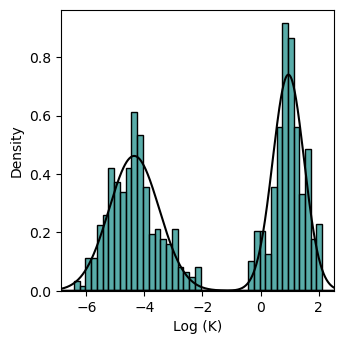

In [242]:
import scipy
boringen.Kweighted
fig, ax = plt.subplots()
fig.set_size_inches(pix1, pix1)
sns.histplot(boringen.Kweighted[boringen.Kweighted['Lithoclass'].isin(boringen.group)], x = 'K', ax = ax, stat = 'density', color = cm(0.5), binwidth = 0.2, linewidth = 1)
sns.histplot(boringen.Kweighted[boringen.Kweighted['Lithoclass'].isin(boringen.group) == False], x = 'K', ax = ax, stat = 'density', color = cm(0.5), binwidth = 0.2, linewidth = 1)
x0,x1 = ax.get_xlim()
x_pdf = np.linspace(x0,x1,1000)

boringen.mu1, boringen.std1 = scipy.stats.norm.fit(boringen.Kweighted[boringen.Kweighted['Lithoclass'].isin(boringen.group)]['K'])
y_pdf1 = scipy.stats.norm.pdf(x_pdf, boringen.mu1, boringen.std1)
ax.plot(x_pdf, y_pdf1, c = 'black')
boringen.mu2, boringen.std2 = scipy.stats.norm.fit(boringen.Kweighted[boringen.Kweighted['Lithoclass'].isin(boringen.group) == False]['K'])
y_pdf2 = scipy.stats.norm.pdf(x_pdf, boringen.mu2, boringen.std2)
ax.plot(x_pdf, y_pdf2, c = 'black')
ax.set_xlabel ('Log (K)')
ax.set_xlim(x0,x1)
fig.tight_layout()
fig.savefig('../Images/Figure_2.pdf')

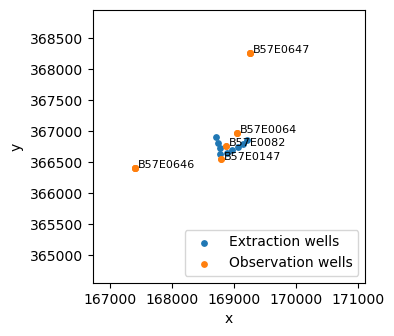

In [146]:
fig, ax = plt.subplots()
fig.set_size_inches(pix1, pix1)
s = 15
marker = 'o'
ax.scatter(x = ExWells.x_coordinaat, y = ExWells.y_coordinaat, label = 'Extraction wells', s=s, marker = marker, zorder =2)
ax.scatter(ObsWells.x_coordinaat, ObsWells.y_coordinaat, label = 'Observation wells', s=s, marker = marker, zorder = 3)
# ax.scatter(boringen.metadata.loc['X-coordinaat (m)'].astype('float'), boringen.metadata.loc['Y-coordinaat (m)'].astype('float'), ec = 'black',fc = 'none', label = 'Boreholes', s=s,zorder = 4, marker = 'o')
ax.set_xlim(ds.extent[0]+1000, ds.extent[1]-1000)
ax.set_ylim(ds.extent[2]+1000, ds.extent[3]-1000)

codes = []
for idx, row in ObsWells.iterrows():
    code = row.putcode.split('_')[0]
    if code not in codes:
        ax.annotate(code, (row.x_coordinaat+50, row.y_coordinaat+1), fontsize = 8)
    codes.append(code)

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.legend(loc = 'lower right')
ax.set_aspect('equal')

In [147]:
resultsBetter['combination_count'] = (
    resultsBetter.groupby(['xcorlen', 'zcorlen', 'cc', 'frac'])
    .transform('size')
)
uc = resultsBetter.drop_duplicates(subset=['xcorlen', 'zcorlen', 'cc', 'frac']).reset_index(drop=True)
uc.sort_values('combination_count', inplace = True, ascending = False)
uc[['xcorlen', 'zcorlen', 'cc', 'frac', 'combination_count']].head(20)

xcorlen  zcorlen   cc  frac  combination_count
126     1000      7.5  1.5 -0.05                 34
5        400      7.5  0.5  0.00                 33
3        400      7.5  1.0  0.00                 32
4        400      7.5  0.0  0.00                 32
10       400      7.5  1.0  0.05                 30
69       700      7.5  1.5  0.00                 29
78       700     10.0  1.0  0.00                 29
97       800      7.5  1.5  0.00                 28
38       600      7.5  1.0 -0.05                 28
157     1200      7.5  1.5 -0.05                 28
40       600      7.5  0.5 -0.05                 27
136     1000     10.0  1.5  0.00                 27
21       500      7.5  1.0  0.00                 27
82       700     10.0  1.5  0.05                 27
95       800      7.5  1.5 -0.05                 26
80       700     10.0  0.5  0.00                 26
65       700      7.5  1.0 -0.05                 25
9        400      7.5  1.5  0.05                 25
46       600      7.5  1.5  0.05                 24
24       500      7.5  1.5  0.05                 24

Botm of layer is not equal to top of deeper layer in 63480 cells


<Figure size 748x748 with 0 Axes>

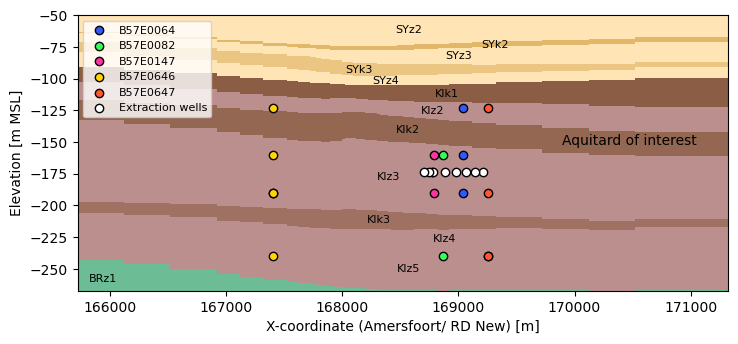

In [259]:
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(pix2, pix2))
fig, ax1  = plt.subplots()
# gs = gridspec.GridSpec(2, 3, height_ratios= [3,2])
fig.set_size_inches(pix2, pix1)

# ax1 = plt.subplot(gs[0,:])
# ax2 = plt.subplot(gs[1,0])
# ax3 = plt.subplot(gs[1,1])

layer_model = nlmod.read.regis.get_combined_layer_models(ds.extent,
    use_regis=True,
    regis_botm_layer="BRz1",
    use_geotop=False)
modelgrid = nlmod.grid.modelgrid_from_ds(ds)
y = layer_model.y.min() + 3100
line = [(ds.extent[0]+800, y), (ds.extent[1], y)]
dcs = nlmod.plot.DatasetCrossSection(ds, line, zmax =-50, ax = ax1 )
colors = nlmod.read.regis.get_legend(kind = 'REGIS')
dcs.plot_layers(colors = colors, min_label_area = 10000, fontsize = 8)
# dcs.plot_grid(vertical=False,horizontal = False, linewidth=0.3)
ax1.set_ylabel('Elevation [m MSL]')
ax1.set_xlabel('X-coordinate (Amersfoort/ RD New) [m]')
# ax1.text(4400, -185, 'Pumped aquifer', ma = 'right')
ax1.text(4175, -152.5, 'Aquitard of interest', ma = 'right')
ax1.text(100, -260, 'BRz1', ma = 'right', fontsize = 8)
ax1.set_facecolor('#6cbc96')


c = {'B57E0647':'#FF5733', 
     'B57E0082': '#33FF57', 
     'B57E0064': '#3357FF', 
     'B57E0147': '#FF33A1', 
     'B57E0646': '#FFD700',}
ax1.scatter(x = ExWells.x_coordinaat-ds.extent[0], y = [-174] * len(ExWells),color = 'white', ec = 'black', label = 'Extraction wells')
def snap_to_closest(value, targets):
    targets = np.array(targets)
    closest_target = targets[np.argmin(np.abs(targets - value))]
    return closest_target
ObsWells['depth'] = -(ObsWells.filter_bovenkant_ref + ObsWells.filter_onderkant_ref )/2+ ObsWells.filter_referentiepunt_NAP
ObsWells['snapped'] = ObsWells['depth'].apply(snap_to_closest, targets = [-123,-160, -190,-240])
for id, row in ObsWells.iterrows():
    ax1.scatter(x = row.x_coordinaat-ds.extent[0], y = row.snapped, ec = 'black', label = row.putcode.split('_')[0], color = c[row.putcode.split('_')[0]])

xticks = ax1.get_xticks()
ax1.set_xticks(xticks[:-1]+279)
ax1.set_xticklabels(xticks[:-1].astype(int) + ds.extent[0]+279)

handles, labels = ax1.get_legend_handles_labels()

unique_labels_handles = {label: handle for handle, label in zip(handles, labels)}
sorted_labels_handles = sorted(unique_labels_handles.items())
sorted_labels, sorted_handles = zip(*sorted_labels_handles)
ax1.legend(sorted_handles, sorted_labels, loc = 'upper left', fontsize = 8)
fig.tight_layout()
fig.savefig('../Images/Figure_1.pdf')

loading simulation...
  loading simulation name file...
  loading tdis package...
  loading model gwf6...
    loading package disv...
    loading package npf...
    loading package ic...
    loading package wel...
    loading package ghb...
    loading package drn...
    loading package oc...
  loading solution package vlen_ss...


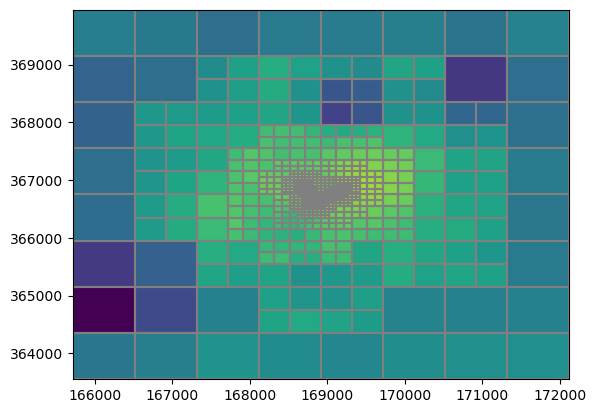

In [270]:
import flopy 



fig, ax = plt.subplots()
pmv = flopy.plot.PlotMapView(gwf, ax = ax)
pmv.plot_array(np.log10(ds.meanbestKV))
pmv.plot_grid()
